In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import samples


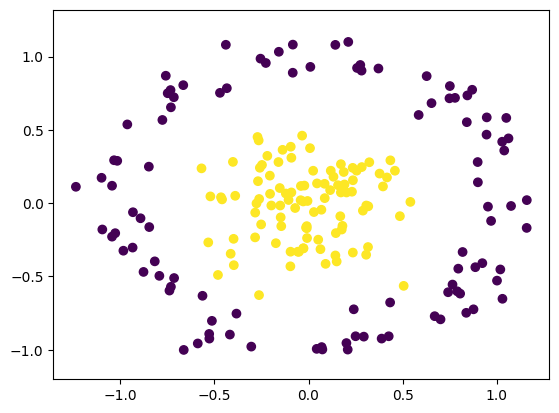

In [4]:
sample = samples.Sample_1(100, 1, 1)
samples.draw_sample(sample)


In [5]:
x, y = sample.__getall__()

class MLP(nn.Module):
    def __init__(self, hidden_layers_num=3, neyrons_num=5, activation_func=nn.ReLU):
        super().__init__()
        hidden_layers = []
        for i in range(hidden_layers_num-1):
            hidden_layers.append(nn.Linear(neyrons_num, neyrons_num, dtype=torch.float64))
            hidden_layers.append(activation_func())
        self.model = nn.Sequential(
            nn.Linear(2, neyrons_num, dtype=torch.float64), 
            activation_func(),        
            *hidden_layers,
            nn.Linear(neyrons_num, 1, dtype=torch.float64),   
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)
    
    def fit(self, X: torch.Tensor, Y: torch.Tensor, epochs=3000, batch_size=20, lr=0.1, tracking_loss=False):
        self.criterion = nn.BCELoss() 
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)

        for epoch in range(epochs):
            self.model.train() # set training mode
            indices = torch.randperm(X.shape[0]) # shuffle data indexes
            x, y = X[indices], Y[indices]
            for i in range(0, X.shape[0], batch_size):
                x_batch, y_batch = x[i:i+batch_size], y[i:i+batch_size]

                outputs = self.model(x_batch)
                loss = self.criterion(outputs, y_batch) 
                
                self.optimizer.zero_grad()
                loss.backward() # backpropagation = FIND GRADIENT
                self.optimizer.step() # update weights

            if (tracking_loss and (epoch+1) % 10 == 0):
                print(f'Epoch [{epoch+1}], Loss: {loss.item():.4f}')
                
    def predict(self, X):
        self.model.eval() # set evaluation mode
        return torch.round(self.forward(X))
        
def draw_results(model, lable=""):
    test = samples.Sample_1(100, 1, 1)
    x, y = test.__getall__()
    Y_pred = model.predict(x)
    plt.scatter(x.numpy()[:,0], x.numpy()[:, 1], c=Y_pred.detach().numpy())
    plt.title(lable)
    plt.show()

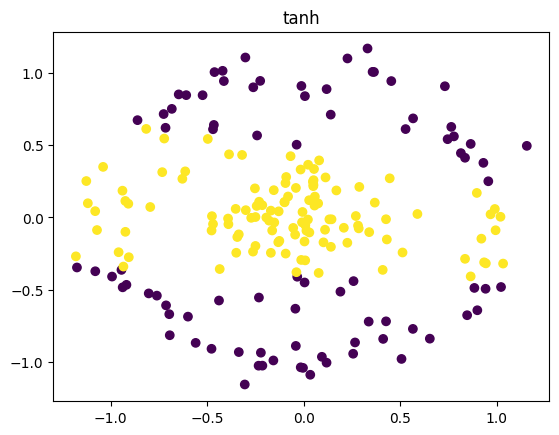

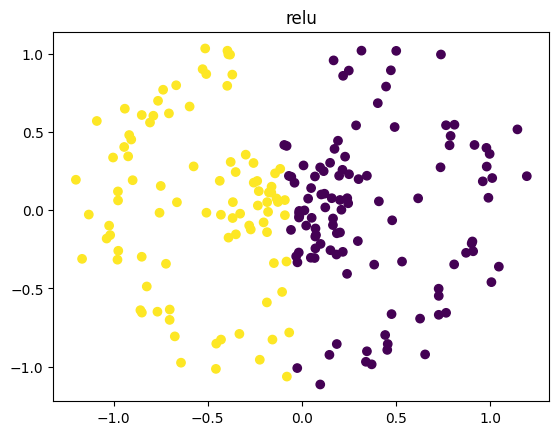

In [7]:
x, y = sample.__getall__()
model = MLP(1, 2, nn.Tanh)
model.fit(x, y, 150, 10, 0.1)
        
draw_results(model, "tanh")

x, y = sample.__getall__()
model = MLP(1, 2, nn.ReLU)
model.fit(x, y, 150, 10, 0.1)
        
draw_results(model, "relu")

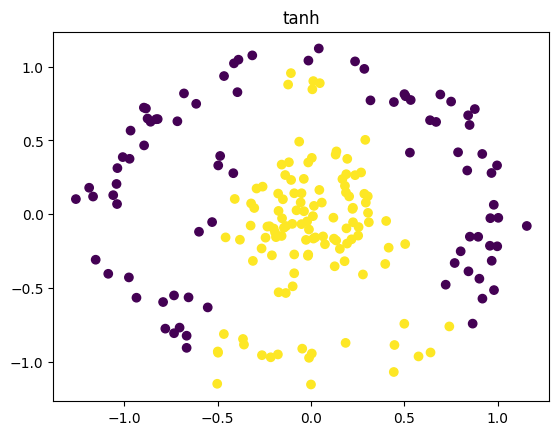

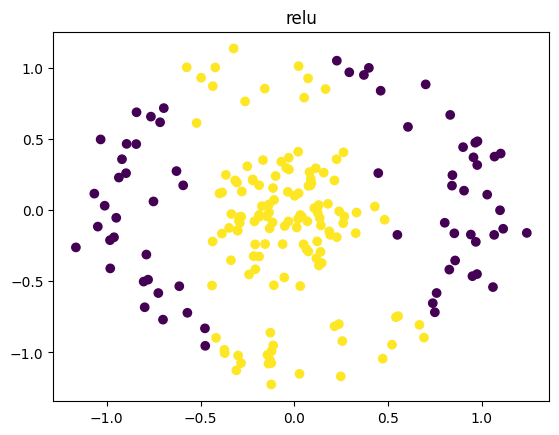

In [10]:
x, y = sample.__getall__()
model = MLP(2, 2, nn.Tanh)
model.fit(x, y, 150, 10, 0.1)
        
draw_results(model, "tanh")

x, y = sample.__getall__()
model = MLP(2, 2, nn.ReLU)
model.fit(x, y, 150, 10, 0.1)
        
draw_results(model, "relu")

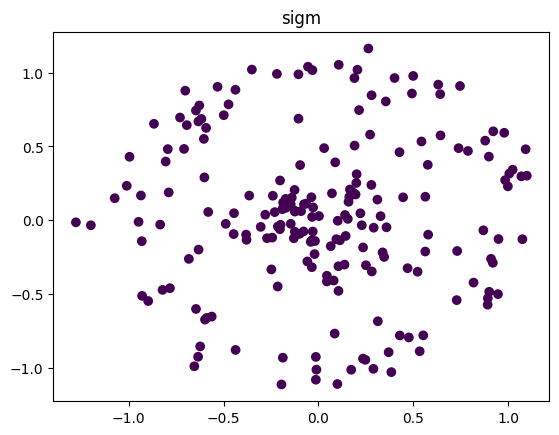

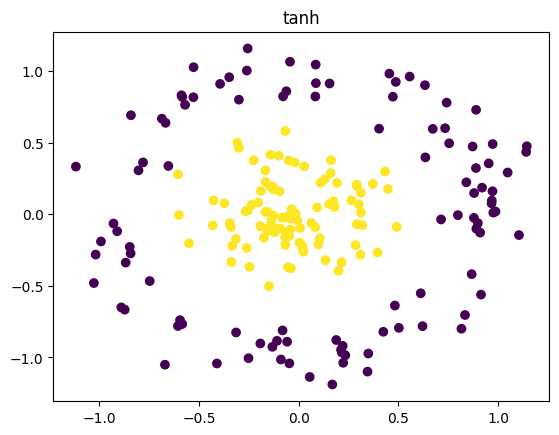

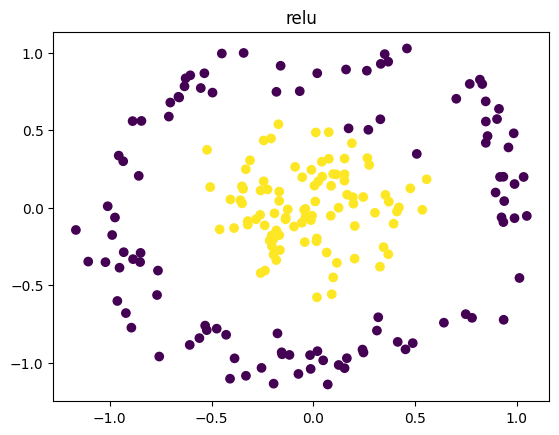

In [20]:
x, y = sample.__getall__()
model = MLP(10, 10, nn.Sigmoid)
model.fit(x, y, 300, 10, 0.01)
        
draw_results(model, "sigm")

x, y = sample.__getall__()
model = MLP(3, 3, nn.Tanh)
model.fit(x, y, 250, 10, 0.1)
        
draw_results(model, "tanh")

x, y = sample.__getall__()
model = MLP(3, 3, nn.ReLU)
model.fit(x, y, 250, 10, 0.1)
        
draw_results(model, "relu")

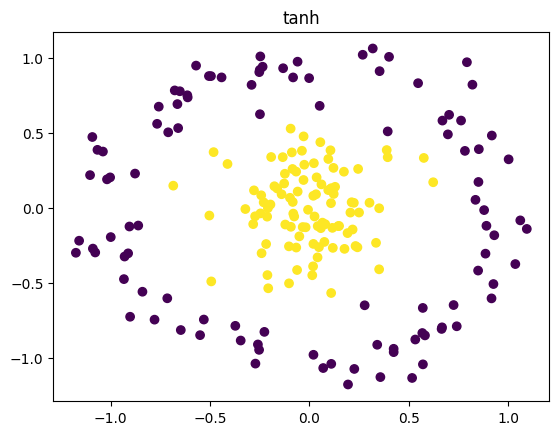

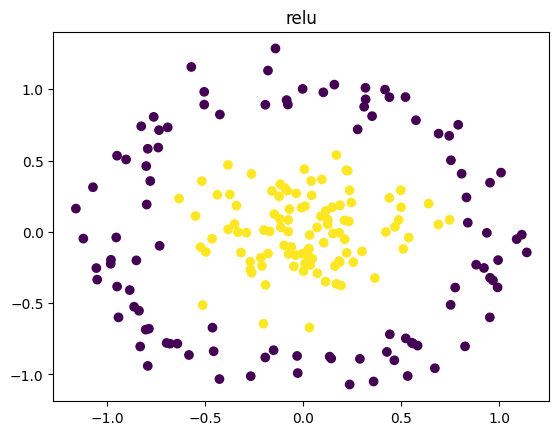

In [12]:
x, y = sample.__getall__()
model = MLP(3, 5, nn.Tanh)
model.fit(x, y, 150, 10, 0.1)
        
draw_results(model, "tanh")

x, y = sample.__getall__()
model = MLP(3, 5, nn.ReLU)
model.fit(x, y, 150, 10, 0.1)
        
draw_results(model, "relu")

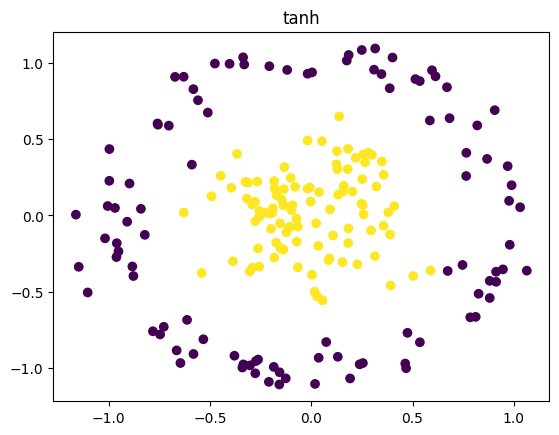

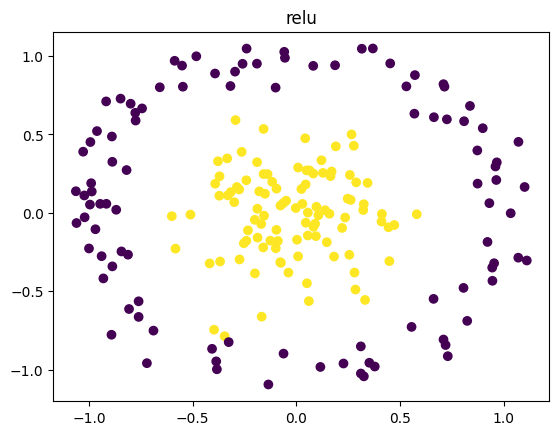

In [12]:
x, y = sample.__getall__()
model = MLP(4, 5, nn.Tanh)
model.fit(x, y, 150, 10, 0.001)
        
draw_results(model, "tanh")

x, y = sample.__getall__()
model = MLP(4, 5, nn.ReLU)
model.fit(x, y, 150, 10, 0.001)
        
draw_results(model, "relu")

In [13]:
from threading import Thread

def messure_acc(x, y, x_test, y_test, results, index):
    model = MLP(4, 5, nn.Tanh)
    model.fit(x, y, 250, 10, 0.001)
    y_pred = model.predict(x_test)
    results[index] = (y_pred == y_test).float().mean()
    
def get_n_messures(n, x, y, x_test, y_test):
    accs = n * [0]
    thrs = []
    for j in range(n):
        thr = Thread(target=messure_acc, args=(x, y, x_test, y_test, accs, j))
        thr.start()
        thrs.append(thr)
    for j in range(n):
        thrs[j].join()
    return accs

def find_accuracy(level_of_accuracy):
    n = 10
    acc = 0
    test = samples.Sample_1(100, 1, 1)
    x_test, y_test = test.__getall__()
    while acc < level_of_accuracy:
        train = samples.Sample_1(n, 1, 1)
        x, y = train.__getall__()
        acc = np.mean(get_n_messures(15, x, y, x_test, y_test))
        print(acc)
        n += 2
    print(2*n)
    
find_accuracy(0.9) # n=64

0.7173332
0.721
0.71566665
0.67700005
0.87733346
0.8656667
0.8273334
0.851
0.88033324
0.8543333
0.9526666
64


In [37]:
from sklearn.metrics import f1_score

def cros_val(X, Y, model, epochs, batch_size, l_rate, folds):
    indices = torch.randperm(X.shape[0])
    X = X[indices]
    Y = Y[indices]
    fold_size = X.shape[0] // folds
    scores = []
    for i in range(folds):
        x_test = X[i*fold_size:(i+1)*fold_size]
        y_test = Y[i*fold_size:(i+1)*fold_size]
        x_train = torch.cat([X[:i*fold_size], X[(i+1)*fold_size:]])
        y_train = torch.cat([Y[:i*fold_size], Y[(i+1)*fold_size:]])
        model.fit(x_train, y_train, epochs, batch_size, l_rate)
        y_pred = model.predict(x_test)
        with torch.no_grad():
            scores.append(f1_score(y_test, y_pred))
    return np.mean(scores)

X, Y = samples.Sample_1(100, 1, 1).__getall__()
act_funcs = [nn.Tanh, nn.ReLU]
hiden_layers = [2, 3, 4, 5]
        

In [39]:
for act_func in act_funcs:
    model = MLP(3, 5, act_func)
    print(act_func, cros_val(X, Y, model, 250, 10, 0.001, 10))

<class 'torch.nn.modules.activation.Tanh'> 0.9875
<class 'torch.nn.modules.activation.ReLU'> 0.9811258581235698


In [43]:
for hiden_layer in hiden_layers: 
    model = MLP(hiden_layer, 5, nn.Tanh)
    print(hiden_layer, cros_val(X, Y, model, 100, 10, 0.01, 10))

2 0.9631653729378862
3 0.9899749373433584
4 0.9831521739130433
5 0.9468877630797137
